# 步骤
## 模型构建
1. 函数式API
2. 自定义
3. 老版本的tf.Module

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time

# tf.data
```
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)


```

支持的其他数据格式：
- NumPy 输入数据，前提是您的数据很小且适合装入内存
- `Dataset` 对象，前提是您有大型数据集，且需要执行分布式训练
- `Sequence` 对象，前提是您具有大型数据集，且需要执行很多无法在 TensorFlow 中完成的自定义 Python 端处理（例如，如果您依赖外部库进行数据加载或预处理）。


# 训练与评估一节

## 自定义标准的loss与metrics

1) 自定义loss：
1. 直接定义相关函数：接受参数y_true, y_pred
2. 继承keras.losses.Loss（需要实现`__init__()`，与`call(self, y_true, y_pred)`方法,其中`__init__()`方法可以实现接受除y_true,y_pred以外的参数）

2) 自定义metrics，需要继承`tf.keras.metrics.Metric`并实现四个`method`：
- `__init__(self)`，您将在其中为指标创建状态变量。
- `update_state(self, y_true, y_pred, sample_weight=None)`，使用目标 y_true 和模型预测 y_pred 更新状态变量。
- `result(self)`，使用状态变量来计算最终结果。
- `reset_states(self)`，用于重新初始化指标的状态。

  状态更新和结果计算分开保存（分别保存在 `update_state()` 和 `result()` 中），因为在某些情况下，结果计算的开销可能会非常大，并且只能定期执行
  
## 自定义非标准化loss与metrics
可以从自定义层的调用方法内部调用 self.add_loss(loss_value)。以这种方式添加的损失会在训练期间添加到“主要”损失中（传递给 compile() 的损失）。（例子很有意思，原样输出，仅仅激活层，增加一个loss。参考1.3.4）

> 请注意，当您通过 add_loss() 传递损失时，可以在没有损失函数的情况下调用 compile()，因为模型已经有损失要最小化--参考例子类LogisticEndpoint

同理，`add_metrics`


## 样本加权与类加权
### 类加权
通过将字典传递给 `Model.fit()` 的 `class_weight` 参数来进行设置。此字典会将类索引映射到应当用于属于此类的样本的权重。

这可用于在不重采样的情况下平衡类，或者用于训练更加重视特定类的模型。

### 样本权重

对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。

- 通过 NumPy 数据进行训练时：将 `sample_weight` 参数传递给 `Model.fit()`。
- 通过 `tf.data` 或任何其他类型的迭代器进行训练时：产生 `(input_batch, label_batch, sample_weight_batch)` 元组。

“样本权重”数组是一个由数字组成的数组，这些数字用于指定批次中每个样本在计算总损失时应当具有的权重。它通常用于不平衡的分类问题（理念是将更多权重分配给罕见类）。

当使用的权重为 1 和 0 时，此数组可用作损失函数的*掩码*（完全丢弃某些样本对总损失的贡献）。

## 多输入与多输出制定（fit函数中）
此时还可以指定不同的类不同损失权重

## 使用回调（功能好多）

Keras 中的回调是训练期间（某个周期开始时、某个批次结束时、某个周期结束时等）在不同时间点调用的对象，这些对象可用于实现以下行为：

- 在训练期间的不同时间点进行验证（除了内置的按周期验证外）
- 定期或在超过一定准确率阈值时为模型设置检查点
- 当训练似乎停滞不前时，更改模型的学习率
- 当训练似乎停滞不前时，对顶层进行微调
- 在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
- 等等

回调可以作为列表传递给您对 `fit()` 的调用


### 编写您自己的回调

您可以通过扩展基类 `keras.callbacks.Callback` 来创建自定义回调。回调可以通过类属性 `self.model` 访问其关联的模型。

such as：keras.callbacks.ModelCheckpoint

## 学习率调节
调节学习率，可以参数化：keras.optimizers.schedules.ExponentialDecay

并将其传递给：optimizer的learning_rate

@TODO 还可以动态调节

## 可视化训练期间的损失和指标

在训练期间密切关注模型的最佳方法是使用 [TensorBoard](https://tensorflow.google.cn/tensorboard)，这是一个基于浏览器的应用，它可以在本地运行，为您提供：

- 训练和评估的实时损失和指标图
- （可选）层激活直方图的可视化
- （可选）`Embedding` 层学习的嵌入空间的 3D 可视化

# 自定义层与模型

## Layer类：状态（权重）和部分计算的组合

Keras的一个中心抽象是 `Layer` 类。封装了状态（即权重w，b）以及计算（输入到输出），即层的<font color=red>前向传递</font>过程。

### 添加权重
#### 方法1：\_\_init\_\_中，需要知道输入的shape
`__init__()`中添加

**<font color = red>核心部分是如何添加weights与bias</font>**
- 方法1：layers.w = w  ,layers.b=b
- 方法2：add_weight，更简单

权重(w,b)被设置后，可以被layer自动跟踪：(`assert linear_layer.weights == [linear_layer.w, linear_layer.b]`, `linear_layer`为自定义层对象)

还可以增加不可训练权重（感觉可以在迁移学习时使用）

#### 方法2：build方法，知道shape时才创建

**<font color = red>build方法创建层的权重，\_\_call()\_\_首次调用时自行构建</font>**

此时必须实现2个方法 `build(self, input_shape)`（创建权重）， `call(self, inputs)`（前向计算）
### call函数支持：mask
它会出现在所有 Keras RNN 层中。掩码是布尔张量（在输入中每个时间步骤对应一个布尔值），用于在处理时间序列数据时跳过某些输入时间步骤。

当先前的层生成了掩码时，Keras 会自动将正确的 mask 参数传递给 __call__()（针对支持它的层）。掩码生成层是配置了 mask_zero=True 的 Embedding 层和 Masking 层。
### 层的递归组合（即层里面包含层）实现
如果层里面还包含层，最好在`__init__()`函数中

### add_loss添加自定义loss:call方法中调用

### add_metric添加自定义指标:call方法中调用

### 序列化：实现get_config/反序实现from_config

例子很精彩：将``**kwargs``传入，比如说name，dtype


## Model与layes常用组合
通常，使用 Layer 类来定义内部计算块，并使用 Model 类来定义外部模型，即训练的对象。

例子很清晰，在 ResNet50 模型中，会有几个子类化`Layer`的`ResNet`块，和一个包含了整个`ResNet50`网络的单个`Model`

`Model` 类具有与 `Layer` 相同的 API，但有如下区别：

- 它会公开内置训练、评估和预测循环（`model.fit()`、`model.evaluate()`、`model.predict()`）。
- 它会通过 `model.layers` 属性公开其内部层的列表。
- 它会公开保存和序列化 API（`save()`、`save_weights()`…）

实际上，`Layer` 类对应于我们在文献中所称的“层”（如“卷积层”或“循环层”）或“块”（如“ResNet 块”或“Inception 块”）。

同时，`Model` 类对应于文献中所称的“模型”（如“深度学习模型”）或“网络”（如“深度神经网络”）。


tips：
> 因此，如果您想知道“我应该用 `Layer` 类还是 `Model` 类？”，请问自己：我是否需要在它上面调用 `fit()`？我是否需要在它上面调用 `save()`？如果是，则使用 `Model`。如果不是（要么因为您的类只是更大系统中的一个块，要么因为您正在自己编写训练和保存代码），则使用 `Layer`。




# 自定义fit函数
自定义算法，并且使用fit的其他api，重载Model的`tran_step(self, data)`函数实现自定义fit函数。

data类型可以是numpy arrays,(x, y)的tuple，与`tf.data.Dataset`

## 重载Model.train_step函数
典型自定义的train_step函数包含以下信息：
1. GradientTape记录梯度相关上下文信息，其中self.compiled_loss去wrap一个loss
2. loss与trainable_vars传入tape.gradient()函数中求梯度
3. gradient传入self.optimizer.apply_gradients
4. 其中loss，metrics可以在
    - 方法1：先定义，train_step中update等
    - 方法2：compile中传参
    
还支持sample_weight,class_weight

tips:
> @property
    def metrics(self):
  返回需要更新的指标

## 重载model.test_step函数
如果要自定义model.evalute()函数，需要重载test_step函数




## other
validation_split：相当于自动设置训练集与测试集

# 从头开始编写训练循环（Writing a training loop from scratch）

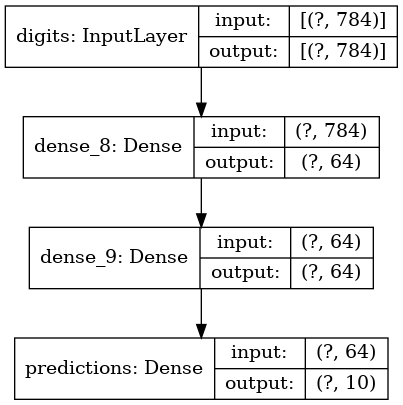

In [17]:
# 生成训练/测试数据
# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

# 定义一个基础模型
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model, "../../../../learnMLData/img/gt_test.png", show_shapes=True)

In [18]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 增加自定义的评价指标
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()


## 非加速且增加评价版本

In [14]:
# 训练
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.4654
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3972
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3082
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5614
Seen so far: 38464 samples
Training acc over epoch: 0.0000
Validation acc: 0.8736
Time taken: 3.02s

Start of epoch 1
Training loss (for one batch) at step 0: 0.2988
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.4463
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.2617
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4347
Seen so far: 38464 samples
Training acc over epoch: 0.0000
Validation acc: 0.8809
Time taken: 2.86s


## 加速版

In [16]:
# train_step函数定义了梯度计算，loss计算，optimizer更新参数
# 
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # 更新此epochs的metrics的状态
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.5030
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.3076
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6766
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.2632
Seen so far: 38464 samples
Training acc over epoch: 0.9140
Validation acc: 0.9051
Time taken: 0.86s

Start of epoch 1
Training loss (for one batch) at step 0: 0.2369
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.4718
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.1029
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4489
Seen so far: 38464 samples
Training acc over epoch: 0.9215
Validation acc: 0.9145
Time taken: 0.61s


## 更深度定制：增加loss

In [20]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu")(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        # Add any extra losses created during the forward pass.
        loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


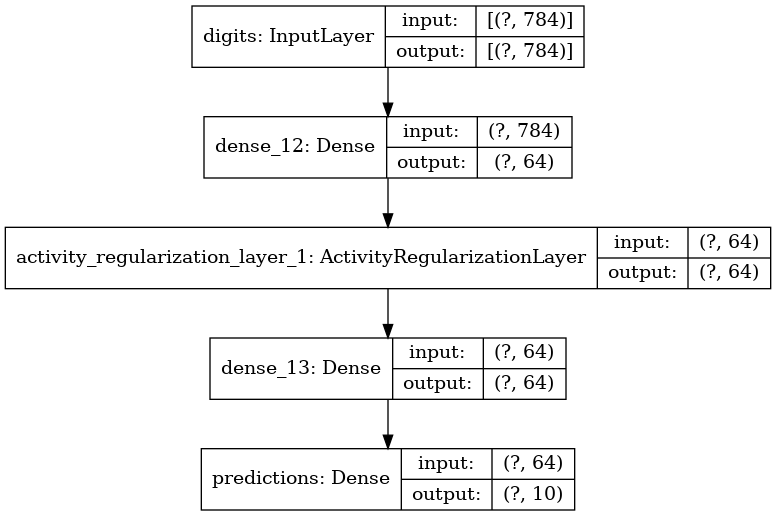

In [21]:
keras.utils.plot_model(model, "../../../../learnMLData/img/gt_test.png", show_shapes=True)

In [22]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 2070.9939
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3028
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.5472
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3019
Seen so far: 38464 samples
Training acc over epoch: 0.1129
Validation acc: 0.0000
Time taken: 0.92s

Start of epoch 1
Training loss (for one batch) at step 0: 2.3026
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3023
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3014
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3034
Seen so far: 38464 samples
Training acc over epoch: 0.1136
Validation acc: 0.0000
Time taken: 0.67s


# 自定义callbacks
以下函数可以被传入callbacks
- `keras.Model.fit()`
- `keras.Model.evaluate()`
- `keras.Model.predict()`

## 全局方法
`on_(train|test|predict)_begin(self, logs=None)`
`on_(train|test|predict)_end(self, logs=None)`

在`fit/evaluate/predict`开始结尾处调用

## 批处理时
`on_(train|test|predict)_batch_begin(self, batch, logs=None)`
`on_(train|test|predict)_batch_end(self, batch, logs=None)
`

同上

## epoch时

`on_epoch_begin(self, epoch, logs=None)`
`on_epoch_end(self, epoch, logs=None)`

同上

In [23]:
# Define the Keras model to add callbacks to
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(1, input_dim=784))
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

# Limit the data to 1000 samples
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:1000]
y_test = y_test[:1000]



In [24]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [25]:
model = get_model()
model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=1,
    verbose=0,
    validation_split=0.5,
    callbacks=[CustomCallback()],
)

res = model.evaluate(
    x_test, y_test, batch_size=128, verbose=0, callbacks=[CustomCallback()]
)

res = model.predict(x_test, batch_size=128, callbacks=[CustomCallback()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'mean_absolute_error']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'mean_absolute_error']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'mean_absolute_error']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'mean_absolute_error']
Start testing; got log keys: []
...Evaluating: start of batch 0; got log keys: []
...Evaluating: end of batch 0; got log keys: ['loss', 'mean_absolute_error']
...Evaluating: start of batch 1; got log keys: []
...Evaluating: end of batch 1; got log keys: ['loss', 'mean_absolute_error']
...Evaluating: start of batch 2; got log keys: []
...Evaluating: end of batch 2; got log keys: ['loss', 'mean_absolute_error']
...Evaluating: 

## 可以使用元素
`logs` dict：包含了loss value，与所有的在batch/epoch结束时的metrics

self.model属性：除了访问logs字典，还可以通过tf.model访问
- self.model.stop_training = True：中断训练
- 修改超参数（self.model.optimizer包含很多超参数，如learning_rate）
- 定期保存模型
- 记录小部分测试样本的model.predict()输出to use as a sanity check during training.
- 在每个时期结束时提取中间特征的可视化，以监视模型随时间推移正在学习的内容。
- etc.

早停策略设置见《Keras09-编写自定义回调》